In [51]:
import json, random
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pickle
import copy
import spacy
from spacy import displacy
from itertools import tee
import wikipedia
import pylcs
import string
np.set_printoptions(precision=4)

In [81]:
PUNCTUATIONS = set(string.punctuation)
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*|\(|\)|-')

In [4]:
img_meta = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data/img_metadata-Copy1.json", "r"))
print(len(img_meta))

362367


In [30]:
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_J_0623-Copy1.json", "r"))
print(len(img_dataset))

25467


In [76]:
pos_list = ['NUM', 'NOUN', 'ADJ', 'PROPN']

In [6]:
nlp = spacy.load('en_core_web_sm')

In [113]:
def IoU(A, B):
    intersection = len(A.intersection(B))
    union = len(A.union(B))
    return round(intersection / (union+1e-7), 2)

In [35]:
[(t.pos_, t.text) for t in nlp('"Which road is thinner, the Main road Shanischara Temple, Morena or the main road of Armenia, Gagarin?"')]

[('PUNCT', '"'),
 ('DET', 'Which'),
 ('NOUN', 'road'),
 ('AUX', 'is'),
 ('ADJ', 'thinner'),
 ('PUNCT', ','),
 ('DET', 'the'),
 ('ADJ', 'Main'),
 ('NOUN', 'road'),
 ('PROPN', 'Shanischara'),
 ('PROPN', 'Temple'),
 ('PUNCT', ','),
 ('PROPN', 'Morena'),
 ('CCONJ', 'or'),
 ('DET', 'the'),
 ('ADJ', 'main'),
 ('NOUN', 'road'),
 ('ADP', 'of'),
 ('PROPN', 'Armenia'),
 ('PUNCT', ','),
 ('PROPN', 'Gagarin'),
 ('PUNCT', '?'),
 ('PUNCT', '"')]

In [110]:
def find_sentences_from_page_for_img_data(title, page, keywords, answerwords):
    try: 
        content = wikipedia.page(title, auto_suggest=False, redirect=True).content
        paragraphs = content[:content.find('== References ==')].split('\n')
        
    except: return {}
    #records = []
    sen2score = {}
    for p in paragraphs:
        if len(p.split()) >= 10:
            #records.append(-999)
            doc = nlp(p)
            for s in doc.sents:
                if len(s) < 10: 
                    continue
                nouns_in_s = [t.text for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]

                IoU_Q = IoU(set(nouns_in_s), keywords)
                IoU_A = IoU(set(nouns_in_s), answerwords)
                if IoU_Q -  IoU_A > 0.06:
                    sen2score[s.text] = {'scores': (IoU_Q, IoU_A, IoU_Q - IoU_A), 'link': page, 'title': title}
                #records.append(round(IoU_Q, 2))
    #print(records)

    #records = []
    for p in paragraphs:
        if len(p.split()) >= 10:
            #records.append(-999)
            doc = nlp(p)
            it1, it2 = tee(doc.sents)
            next(it2, None)
            for s1, s2 in zip(it1, it2):
                if len(s1) < 5 or len(s2) < 5 or len(s1)+len(s2) > 70 or len(s1)+len(s2) < 10: 
                    continue 
                nouns_in_s = [t.text for s in [s1, s2] for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]

                IoU_Q = IoU(set(nouns_in_s), keywords)
                IoU_A = IoU(set(nouns_in_s), answerwords)
                if IoU_Q -  IoU_A >= 0.06:
                    sen2score[" ".join([s1.text, s2.text])] = {'scores': (IoU_Q, IoU_A, IoU_Q - IoU_A), 'link': page, 'title': title}
                    #print(s)
                #records.append(round(IoU_Q, 2))
    #print(records)
    #print(len(sen2score))
    return sen2score

In [480]:
def get_keywords_from_img_sample(k):
    Q = img_dataset[str(k)]['Q'].replace('"', '').replace('_', ' ')
    doc = nlp(Q)
    keywords = set([t.text for s in doc.sents for t in s if t.pos_ in ['NUM', 'PROPN', 'ADJ', 'NOUN'] or ((not t.is_sent_start) and t.text[0].isupper())])
    keywords = keywords - PUNCTUATIONS
    
    ### Extract noun chunks
    proper_words = [t.text for s in doc.sents for t in s if t.pos_ in ['NUM', 'PROPN', 'ADJ'] or ((not t.is_sent_start) and t.text[0].isupper())]
    chunks = set()
    for chunk in doc.noun_chunks:
        if any([n in proper_words for n in chunk.text.split()]):
            chunks.add(chunk.text)
    if not chunks: 
        chunks = chunks.union([c.text for c in doc.noun_chunks])
        chunks = chunks.union([t.text for s in doc.sents for t in s if t.pos_ == 'PROPN' or ((not t.is_sent_start) and t.text[0].isupper())])
    
    A = img_dataset[str(k)]['A'].replace('"', '')
    doc = nlp(A)
    answerwords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    answerwords = answerwords - PUNCTUATIONS
    
    
    return keywords, answerwords, Q, A, chunks

In [447]:
for k in record:
    keywords, answerwords, Q, A, chunks = get_keywords_from_img_sample(k)
    #pages = noun_chunk2candidate_page(chunks)
    if len(record[k]['pages']) == 0:
        
        print(k)
        print(Q)
        print(A)
        print(keywords)
        print(chunks)
        print(record[k]['chunks'])
        print(' --------------------------------------------- ')

11689
Is the beak of the White-bellied Woodstar skinny or fat?
Skinny
{'Woodstar', 'skinny', 'beak', 'fat', 'White'}
['the White-bellied Woodstar skinny']
['the White-bellied Woodstar skinny', 'bellied Woodstar skinny', 'Woodstar skinny', 'bellied Woodstar skinny', 'Woodstar skinny']
 --------------------------------------------- 
2621
What materials were used for the roofs on top of the huts at the Ansakket Festival?
Pop bottles and straw
{'top', 'Ansakket', 'materials', 'huts', 'Festival', 'roofs'}
['the Ansakket Festival']
['the Ansakket Festival', 'Ansakket Festival', 'Ansakket Festival']
 --------------------------------------------- 
11616
Is the base of the Mycena alexandri thick or thin?
Thin.
{'base', 'Mycena', 'thin', 'thick', 'alexandri'}
['the Mycena alexandri']
['the Mycena alexandri', 'Mycena alexandri']
 --------------------------------------------- 
12988
Do the flowers of the Allium aflatuense grow in bunches?
Yes.
{'flowers', 'bunches', 'Allium', 'aflatuense'}
['the A

In [464]:
doc = nlp("What colors are the Cheverny and Dicentra cucullaria flowers?")
for c in doc.noun_chunks:
    print(c.text)
displacy.render(doc, style='dep')

What colors
the Cheverny and Dicentra cucullaria flowers


In [465]:
for token in doc:
    if token.dep_ == 'amod' or token.dep_ == 'compound':
        print(token.i, token.head.i)
        print(doc[token.i: token.head.i+1].text if token.head.i > token.i else doc[token.head.i:token.i+1].text)

7 8
cucullaria flowers


In [429]:
wikipedia.search('sea anemone')

['Sea anemone',
 'Amphiprioninae',
 'Starlet sea anemone',
 'Dofleinia',
 'Snakelocks anemone',
 'Sea anemone dermatitis',
 'Heteractis magnifica',
 'Monactis (sea anemone)',
 'Venus flytrap sea anemone',
 "Ivell's sea anemone"]

In [483]:
print(Counter([len(record[k]['chunks']) for k in record]))
print(Counter([len(record[k]['pages']) for k in record]))

Counter({2: 655, 3: 524, 1: 377, 4: 240, 5: 128, 6: 46, 7: 18, 8: 8, 9: 3, 10: 1})
Counter({20: 517, 10: 358, 30: 340, 40: 128, 29: 74, 50: 65, 39: 52, 19: 47, 49: 28, 27: 23, 18: 22, 28: 18, 14: 16, 60: 16, 11: 13, 38: 12, 23: 11, 25: 11, 24: 11, 13: 11, 12: 11, 26: 10, 35: 10, 48: 10, 16: 10, 59: 9, 47: 9, 21: 9, 37: 9, 33: 8, 36: 8, 70: 8, 45: 7, 69: 7, 5: 6, 41: 6, 58: 5, 7: 5, 46: 5, 17: 5, 34: 4, 57: 4, 32: 4, 15: 4, 22: 4, 8: 4, 68: 4, 31: 4, 55: 4, 63: 2, 44: 2, 43: 2, 53: 2, 67: 2, 80: 2, 90: 2, 0: 2, 9: 2, 66: 1, 56: 1, 78: 1, 79: 1, 51: 1, 97: 1, 71: 1, 52: 1, 54: 1, 86: 1, 65: 1, 73: 1, 1: 1, 146: 1, 62: 1, 6: 1})


In [471]:
wikipedia.search('Dicentra')

['Dicentra',
 'Dicentra cucullaria',
 'Dicentra eximia',
 'Lamprocapnos',
 'Dicentra formosa',
 'Dicentra peregrina',
 'Dicentra canadensis',
 'Stenoma dicentra',
 'Dactylicapnos',
 'Papaveraceae']

In [482]:
record = defaultdict(lambda: {})
for k in random.sample(list(img_dataset.keys()), 2000):
    #k=8916
    keywords, answerwords, Q, A, chunks = get_keywords_from_img_sample(k)
    record[k] = {'chunks': chunks, 'pages': noun_chunk2candidate_page(chunks, k)}
    if len(record)%200 == 0: print(len(record))


19781
Do you put gas on the driver side or passenger side of the Suzuki Samurai SJ 413 QX 1989?
More chunks:  {'Suzuki', 'QX', 'passenger side', 'Samurai', 'driver side', 'SJ'}
add 6 more chunks, 55 more pages
8925
Does the center of the Aeonium Subplanum or the Aeonium Korneliuslemsii plant look more like a rose?
More chunks:  {'Aeonium', 'Aeonium Subplanum', 'Korneliuslemsii plant', 'Subplanum', 'Aeonium Korneliuslemsii', 'Korneliuslemsii'}
add 6 more chunks, 11 more pages
200
10135
Is the text at Nikko Toshogu Outer Torii written vertically or horizontally?
More chunks:  {'Nikko', 'Toshogu', 'Outer Torii', 'Torii', 'Outer', 'Nikko Toshogu', 'Toshogu Outer Torii'}
add 7 more chunks, 53 more pages
8336
Do Assaf sheep's ears droop below their jawline?
More chunks:  {'Assaf', 'Assaf sheep'}
add 2 more chunks, 18 more pages
12480
What shade fur does the underbelly of Malabar giant sqirrel have?
More chunks:  {'shade fur', 'Malabar', 'giant sqirrel'}
add 3 more chunks, 23 more pages
8317


675
Does one of the windows in Hogsmeade feature sports equipment?
More chunks:  {'feature sports', 'sports equipment', 'Hogsmeade'}
add 3 more chunks, 30 more pages
1800
2000


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


0.0265


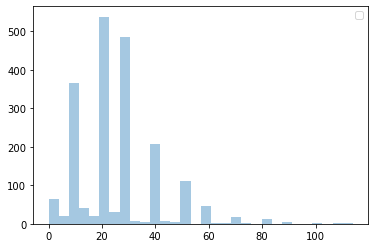

In [244]:
print(np.sum(np.array(x) == 0) / len(x))
sns.distplot(x, kde=False, bins=30)
plt.legend()

In [487]:
# Given img_dataset indx & title, find sentences with word overlap with the question
def find_sentences_from_indx_for_img(k, keywords, answerwords, chunks):
    sen2score = {}
    candidate_pages, updated_chunks = noun_chunk2candidate_page(chunks, k)
    print("num of candidate pages = {}\n".format(len(candidate_pages)))
    for title in candidate_pages:
        page = "https://en.wikipedia.org/wiki/" + "_".join(title.split())
        sen2score.update(find_sentences_from_page_for_img_data(title, page, keywords, answerwords))
    sen2score = dict(sorted(sen2score.items(), key=lambda x: x[1]['scores'][0], reverse=True))
    return sen2score, candidate_pages, updated_chunks

In [199]:
for k in [345, 678, 456, 1297, 9099, 4738]:
    d, word_lists = find_sentences_from_indx_for_img(k)
    for k in list(d.keys())[:10]:
    
        print(k)
        print(d[k])
        print(' ')
    print(' ------------------------------------------------------------ \n')

Q =  What color did Croatia's goalkeeper wear in the 2018 FIFA World Cup Match 64, France v Croatia?
Keywords = {'Cup', 'color', 'Match', 'World', 'France', 'wear', '2018', 'goalkeeper', 'Croatia', 'FIFA', '64'}
Gold img: Croatia_WC2018_final - 
A =  "Green"
answerwords = {'Green'}
 
keywords used to find noun chunks:  ['Croatia', '2018', 'FIFA', 'World', 'Cup', 'Match', '64', 'France', 'Croatia']
noun chunk :  What color
noun chunk :  Croatia's goalkeeper wear
noun chunk :  the 2018 FIFA World Cup Match
noun chunk :  France
noun chunk :  Croatia
num of candidate pages = 30



/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


France won the 2018 FIFA World Cup, defeating Croatia 4–2 in the final match on 15 July 2018.
{'scores': (0.37, 0.0, 0.37), 'link': 'https://en.wikipedia.org/wiki/France_national_football_team', 'title': 'France national football team'}
 
In 2018, France defeated Croatia 4–2 in the final match and won the World Cup for the second time.
{'scores': (0.31, 0.0, 0.31), 'link': 'https://en.wikipedia.org/wiki/France_national_football_team', 'title': 'France national football team'}
 
Before 2018, France's only World Cup victory was in 1998 – though they had also reached the final in 2006 – while Croatia were playing in their first World Cup final.
{'scores': (0.29, 0.0, 0.29), 'link': 'https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_Final', 'title': '2018 FIFA World Cup Final'}
 
The winners of each group qualified for the 2018 FIFA World Cup.
{'scores': (0.29, 0.0, 0.29), 'link': 'https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_qualification', 'title': '2018 FIFA World Cup qualification

noun chunk :  light
num of candidate pages = 10

San Francisco City Hall is the seat of government for the City and County of San Francisco, California.
{'scores': (0.33, 0.0, 0.33), 'link': 'https://en.wikipedia.org/wiki/San_Francisco_City_Hall', 'title': 'San Francisco City Hall'}
 
The beauty of City Hall has not been lost on filmmakers working in San Francisco; many films have shot scenes in and around the building.
{'scores': (0.29, 0.0, 0.29), 'link': 'https://en.wikipedia.org/wiki/San_Francisco_City_Hall', 'title': 'San Francisco City Hall'}
 
The flag of the City and County of San Francisco is a flag representing San Francisco, California.
{'scores': (0.27, 0.0, 0.27), 'link': 'https://en.wikipedia.org/wiki/Flag_of_San_Francisco', 'title': 'Flag of San Francisco'}
 
San Francisco International Airport, though located in San Mateo County, is owned and operated by the City and County of San Francisco.
{'scores': (0.25, 0.0, 0.25), 'link': 'https://en.wikipedia.org/wiki/San_Franci

In [490]:
def add_html_row_x_distractor_for_img(k, sen2score, word_lists, chunks, pages, colors=["(205, 245, 252)", "(255, 214, 222)"]):
    html = '<tr><td>{}.</td>'.format(k)
    Q = img_dataset[str(k)]['Q'].replace('"', '')
    html += '<td>Q: {}<br><br>'.format(highlight_words(word_lists, chunks, colors, Q))
    A = img_dataset[str(k)]['A'].replace('"', '')
    for gid in img_dataset[str(k)]['GoldIds']:
        img = img_meta[str(int(gid))]
        html += '<a href="{}" target="_blank"><img style="display:block; max-height:300px; max-width:100%;" src = "{}"></a>'.format(img['page'], img['src'])
        html += '<br>Title = {}<br>Description = {}<br><br>'.format(highlight_words(word_lists, [], colors, img['name'].replace("_", " ")), highlight_words(word_lists, [], colors, img['description'].replace("_", " ")))
    html += 'A: {}<br><br>'.format(highlight_words(word_lists, [], colors, A))
    html += '<span class="hid" style="display: none"><b>Relevant Wikipedia Pages: </b>{}</span>'.format(', '.join(pages))
    html += '<br><button onclick="btn_click($(this));">Toggle details</button></td><td>'
    
    for s in list(sen2score.keys())[:10]:
        html += '{} --- {} '.format(highlight_words(word_lists, [], colors, s), str(sen2score[s]['scores']))
        html += '<a href="{}"  target="_blank"> {}</a><br><br>'.format(sen2score[s]['link'], sen2score[s]['title'])
    for s in list(sen2score.keys())[10:]:
        html += '<span class="hid" style="display: none">{} --- {} '.format(highlight_words(word_lists, [], colors, s), str(sen2score[s]['scores']))
        html += '<a href="{}"  target="_blank"> {}</a><br><br></span>'.format(sen2score[s]['link'], sen2score[s]['title'])
        
    html += '</td></tr>'
    html += '<tr><td colspan=3><hr></td></tr>'
    return html.encode('ascii', 'xmlcharrefreplace').decode("utf-8") 

In [493]:
html = '<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.1/css/bootstrap.min.css">'
html += '<script src="https://code.jquery.com/jquery-3.2.1.min.js" integrity="sha256-hwg4gsxgFZhOsEEamdOYGBf13FyQuiTwlAQgxVSNgt4=" crossorigin="anonymous"></script>'
html += '<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.1/js/bootstrap.min.js"></script>'
html += '<!DOCTYPE html><html><head><meta http-equiv="content-type" content="text/html; chatset="UTF-8"><body>'
html += '<script>$("img").on("error", function(){console.log($(this).attr("src"));});'
html += 'function btn_click(btn){$(btn).parent().parent().find(".hid").toggle();}</script>'
html += '<style>table {border-collapse: separate;border-spacing: 10px;}\n'
html += '.chunk {text-decoration: underline solid rgb(227, 123, 253) 3px;}\n'
html += 'button {background-color:white; border: 2px solid #4CAF50; color: black; padding: 0px 8px; text-align: center; display: inline-block; font-size: 14px; margin: 4px 2px; transition-duration: 0.4s; cursor: pointer; }'
html += 'button:hover {background-color: #4CAF50;color: white;}</style>'
html += '<table border="0" style="table-layout: fixed; width: 100%; word-break:break-word">'
html += '<tr bgcolor=lightblue style="text-align: center;"><td width=5%>Index</td><td width=35%>Q & Pos Facts</td><td width=60%>Neg Facts</td></tr>'
x = []
for k in [8925, 10135]: #random.sample(range(25467), 2):
    print(k)
    keywords, answerwords, Q, A, chunks = get_keywords_from_img_sample(k)
    print("Q = ", Q)
    print("Keywords = {}".format(keywords))
    print("A = ", A)
    print("answerwords = {}".format(answerwords))
    print("\nNoun chunks: ", chunks)
    print(' ')
    d, pages, chunks = find_sentences_from_indx_for_img(k, keywords, answerwords, chunks)
    x.append(len(d))
    
    word_lists = [keywords, answerwords]
    html += add_html_row_x_distractor_for_img(k, d, word_lists, chunks, pages, colors=["(193, 239, 253)", "(255, 214, 222)"])
    o = open('x_distractor_for_img_demo3.html', 'wt')
    o.write(html)
    o.close()
html += '</table></body></html>'
o = open('x_distractor_for_img_demo3.html', 'wt')
o.write(html)
o.close()

8925
Q =  Does the center of the Aeonium Subplanum or the Aeonium Korneliuslemsii plant look more like a rose?
Keywords = {'Aeonium', 'plant', 'Subplanum', 'center', 'Korneliuslemsii', 'rose'}
A =  Aeonium Subplanum
answerwords = {'Aeonium', 'Subplanum'}

Noun chunks:  {'the Aeonium Subplanum', 'the Aeonium Korneliuslemsii plant'}
 
8925
Does the center of the Aeonium Subplanum or the Aeonium Korneliuslemsii plant look more like a rose?
More chunks:  {'Aeonium', 'Aeonium Subplanum', 'Korneliuslemsii plant', 'Subplanum', 'Aeonium Korneliuslemsii', 'Korneliuslemsii'}
add 6 more chunks, 11 more pages
num of candidate pages = 11

10135
Q =  Is the text at Nikko Toshogu Outer Torii written vertically or horizontally?
Keywords = {'Nikko', 'Toshogu', 'text', 'Torii', 'Outer'}
A =  Vertically.
answerwords = set()

Noun chunks:  {'Nikko Toshogu Outer Torii'}
 
10135
Is the text at Nikko Toshogu Outer Torii written vertically or horizontally?
More chunks:  {'Nikko', 'Toshogu', 'Outer Torii', 'To

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [354]:
def highlight_words(word_lists, chunks, colors, sentence):
    s = copy.deepcopy(sentence)
    if "".join(chunks):
        s = re.sub(r'\s*(' + r'|'.join([re.escape(c) for c in chunks]) + r')\s*', lambda m: '<span class="chunk">{}</span>'.format(m.group()), s)
    for word_list, color in zip(word_lists, colors):
        if "".join(word_list): s = re.sub(r'\b(' + r'|'.join(word_list) + r')\b', lambda m: '<span style="background-color:rgb{}">{}</span>'.format(color, m.group()), s)
    return s

In [488]:
def noun_chunk2candidate_page(chunks, k):
    pages = set()
    for chunk in chunks:
        pages = pages.union(set(wikipedia.search(chunk)))
    if len(pages) < 5:
        print(k)
        Q = img_dataset[str(k)]['Q'].replace('"', '').replace('_', ' ')
        doc = nlp(Q)
        #more_chunks = set([c.text for c in doc.noun_chunks])
        more_chunks = set()
        more_chunks = more_chunks.union([t.text for s in doc.sents for t in s if t.pos_ == 'PROPN' or ((not t.is_sent_start) and t.text[0].isupper())])
        for token in doc:
            if token.dep_ == 'amod' or token.dep_ == 'compound':
                more_chunks.add(doc[token.i: token.head.i+1].text if token.head.i > token.i else doc[token.head.i:token.i+1].text)
        more_chunks = more_chunks - chunks
        print(Q)
        print("More chunks: ", more_chunks)
        more_pages = set()
        for chunk in more_chunks:
            more_pages = more_pages.union(wikipedia.search(chunk))
        print('add {} more chunks, {} more pages'.format(len(more_chunks), len(more_pages)))
        pages = pages.union(more_pages)
        chunks = chunks.union(more_chunks)
    return pages, chunks

In [196]:
for k in random.sample(list(img_dataset.keys()), 1):
    k=123
    print(k)
    Q = img_dataset[str(k)]['Q'].replace('"', '')
    print(Q)
    doc = nlp(Q)
    keywords = [t.text for s in doc.sents for t in s if t.pos_ in ['NUM', 'PROPN', 'ADJ'] or ((not t.is_sent_start) and t.text[0].isupper())]
    print(keywords)
    for chunk in doc.noun_chunks:
        if any([n in keywords for n in chunk.text.split()]):
            print("noun_chunk: ", chunk.text)
            print(wikipedia.search(chunk.text))
    print(' ------------------------------------------- \n')

123
Does the T & T Supermarket in Richmond have a fire extinguisher that is at the front entrance to the left of large, red Chinese letters on a silver wall?
['T', 'T', 'Supermarket', 'Richmond', 'front', 'large', 'red', 'Chinese', 'silver']
noun_chunk:  the T & T Supermarket
['T & T Supermarket', 'T&T', '99 Ranch Market', 'History of AT&T', 'T. R. Knight', 'Supermarket', 'AT&T Center', 'List of supermarket chains in Canada', 'Food City (K-VA-T)', 'Asian supermarket']
noun_chunk:  Richmond
['Richmond', 'Richmond, Virginia', 'Duke of Richmond', 'Richmond, California', 'Cedric Richmond', 'Jeff Richmond', 'Branscombe Richmond', 'Richmond Football Club', 'Richmond, London', 'Lady Margaret Beaufort']
noun_chunk:  the front entrance
['Entryway', 'Entrance pupil', 'AEC Routemaster', 'Ross Castle', 'Porch', 'Dulce et decorum est pro patria mori', '5, The Grove', 'Wardour Castle', 'Parliament Building (Quebec)', 'Cornelius Vanderbilt II House']
noun_chunk:  large, red Chinese letters
['Vermilio

In [64]:
new_txt_data = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "r"))
print(len(new_txt_data))
'''
temp = {}
count = 0
for i in new_txt_data:
    temp[count] = copy.deepcopy(i)
    temp[count]['Q'] = temp[count]['Question']
    temp[count]['A'] = temp[count]['Answer']
    del temp[count]['Question']
    del temp[count]['Answer']
    count += 1
json.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "w"), indent=4)
'''

7921


'\ntemp = {}\ncount = 0\nfor i in new_txt_data:\n    temp[count] = copy.deepcopy(i)\n    temp[count][\'Q\'] = temp[count][\'Question\']\n    temp[count][\'A\'] = temp[count][\'Answer\']\n    del temp[count][\'Question\']\n    del temp[count][\'Answer\']\n    count += 1\njson.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "w"), indent=4)\n'

In [62]:
def sample2keywords(k):
    Q = new_txt_data[str(k)]['Q']
    doc = nlp(Q)
    keywords = set([t.text for s in doc.sents for t in s if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])

    keywords = keywords - PUNCTUATIONS        

    A = new_txt_data[str(k)]['A']
    doc = nlp(A)
    answerwords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    answerwords = answerwords - PUNCTUATIONS

    goldfactwords = set()
    titlewords = set()
    Q_A_words = keywords.union(answerwords)
    for f in new_txt_data[str(k)]['SupportingFacts']:
        doc = nlp(f['fact'])
        goldfactwords = goldfactwords.union(set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())]) - Q_A_words)
        fact_title_raw = ' '.join(urllib.parse.unquote(f['url']).split('/')[-1].split('_'))
        fact_title = pattern.sub('', fact_title_raw)
        titlewords = titlewords.union(fact_title.split())
    goldfactwords = goldfactwords - PUNCTUATIONS 
    titlewords = titlewords - PUNCTUATIONS

    word_lists = [titlewords, keywords, goldfactwords, answerwords]
    return word_lists

In [74]:
def add_html_row_vis_ori_dataset(k, word_lists, colors = ["(223, 255, 238)", "(193, 239, 253)", "(253, 252, 152)", "(255, 214, 222)"]):
    html = ""
    html += '<tr><td>{}.</td><td>Q: {}<br>'.format(k, highlight_words(word_lists, colors, new_txt_data[str(k)]['Q']))
    for f in new_txt_data[str(k)]['SupportingFacts']:
        html += '<br><br>&nbsp;&nbsp;{}'.format(highlight_words(word_lists, colors, f['fact']))
        html += '<a href="{}"> link</a>'.format(f['url'])
    html += '<br><br>A: {}<br>'.format(highlight_words(word_lists, colors, new_txt_data[str(k)]['A']))
    html += '</td><td>'
    
    for f in new_txt_data[str(k)]['DistractorFacts']:            
            html += highlight_words(word_lists, colors, f['fact'])
            html += '<a href="{}"> {}</a><br><br>'.format(f['url'], f['title'])
    html += '</td></tr>'
    html += '<tr><td colspan=3><hr></td></tr>'
    return html

In [86]:
sampled_indx = random.sample(range(7921), 25)

In [103]:
html = "<html><body>"
html += '<table border="0" style="table-layout: fixed; width: 100%; word-break:break-word">'
html += '<tr bgcolor=gray><td width=5%>Index</td><td width=35%>Q & Pos Facts</td><td width=60%>Neg Facts</td></tr>'
count = 0
for k in sampled_indx:
    count += 1
    word_lists = sample2keywords(k)[:2]
    html += add_html_row_vis_ori_dataset(k, word_lists)
    o = open('txt_dataset_vis.html', 'wt')

    o.write(html)
    o.close()
html += '</table></body></html>'
o = open('txt_dataset_vis.html', 'wt')

o.write(html)
o.close()

In [102]:
colors = ["(223, 255, 238)", "(193, 239, 253)", "(253, 252, 152)", "(255, 214, 222)"]
highlight_words(sample2keywords(3816), colors, 'What kind of effect are artificial harmonics and vibrato ?')

'What  <span style="background-color:rgb(193, 239, 253)">kind </span> of  <span style="background-color:rgb(193, 239, 253)">effect </span> are  <span style="background-color:rgb(193, 239, 253)">artificial </span>  <span style="background-color:rgb(193, 239, 253)">harmonics </span> and  <span style="background-color:rgb(193, 239, 253)">vibrato </span> ?'

In [88]:
[(t.pos_, t.text) for t in nlp('What kind of effect are artificial harmonics and vibrato ?')]

[('PRON', 'What'),
 ('NOUN', 'kind'),
 ('ADP', 'of'),
 ('NOUN', 'effect'),
 ('AUX', 'are'),
 ('ADJ', 'artificial'),
 ('NOUN', 'harmonics'),
 ('CCONJ', 'and'),
 ('NOUN', 'vibrato'),
 ('PUNCT', '?')]

In [89]:
sample2keywords(3816)

[{'Csárdás', 'Monti', 'Vibrato'},
 {'artificial', 'effect', 'harmonics', 'kind', 'vibrato'},
 {'24',
  '5',
  'Czardas',
  'Italian',
  'Meno',
  'Monti',
  'Vibrato',
  'change',
  'e',
  'expression',
  'finger',
  'help',
  'higher',
  'instrumental',
  'lento',
  'media',
  'music',
  'musical',
  'note',
  'octaves',
  'participle',
  'past',
  'pianoforte',
  'pitch',
  'quasi',
  'regular',
  'section',
  'semitones',
  'string',
  'two',
  'vibrare',
  'violin',
  'violinist',
  'violino',
  'vocal'},
 {'Musical', 'effects'}]

In [503]:
count = 0
for k in new_txt_data:
    Q = new_txt_data[k]['Q']
    if all([b in Q for b in ['same', ' or ', 'different']]):
        count += 1
        if random.random()<0.1:
            print(k)
            print(Q)
print("Count = ", count)

1442
Were Romario Augusto Vieira Nan and Gustavo Daniel Viera Moreira born during the same or different months of the year?
1728
Was th 2020 ADAC TCR Germany Touring Car Championship and the the 2019 Kwik Fit British Touring Car Championship held in the same country or different countries?
3079
Are the Northern Styrian Alps and the Styrian Prealps proposed mountain range subdivisions in the same or different countries?
3129
Is the Kholmsky District and the Avtozavodsky City District in the same city or different cities?
3682
Are the characters Roland "Wee-Bey" Brice and Felicia " Snoop " Pearson part of the same organization on The Wire or are they from different organizations?
4042
Is Will Guidara's nationality the same country as where he attended culinary school, or is it different?
4161
Did General Orwell Taylor, Abraxas and Danielle Cage all appear for the first time in the same Marvel comic series or did they all appear in different series for their first time?
4293
Are the Santa